<a href="https://colab.research.google.com/github/seoes/odyssey-ai/blob/seo/tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 기본 설정

## 첫 설정

In [65]:
%matplotlib inline
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from IPython.display import clear_output, display, Image
from collections import defaultdict

## YOLOv5 설치

In [60]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Cloning into 'yolov5'...
remote: Enumerating objects: 16083, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 16083 (delta 7), reused 12 (delta 1), pack-reused 16056
Receiving objects: 100% (16083/16083), 14.65 MiB | 11.92 MiB/s, done.
Resolving deltas: 100% (11039/11039), done.
/content/yolov5/yolov5


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-12-3 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 77.0MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


## Supervision 설치

In [61]:
!pip install supervision

import supervision as sv

colors = sv.ColorPalette.default()

# 2. 데이터 세팅

## 영상 다운로드

In [62]:
import os
HOME = os.getcwd()
%cd {HOME}

!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1vcKRPpv7ve1St-0rynhGa-H3lHMyCNt9' -O exhibition-64-sample.mp4
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1ERyxsKGZmJZFgOBKGwVguQFqGJbYu575' -O exhibition-32-sample.mp4
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1Mcp8xRYhsaxE3SfGAUaeJk63rNNkx80d' -O exhibition-4-sample.mp4
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1jEhErOcFKt7JrliQFzMar5yerHkTeu09' -O exhibition-64-full.mp4

/content/yolov5/yolov5
--2023-12-03 13:39:41--  https://drive.google.com/uc?export=download&id=1vcKRPpv7ve1St-0rynhGa-H3lHMyCNt9
Resolving drive.google.com (drive.google.com)... 172.217.194.102, 172.217.194.113, 172.217.194.138, ...
Connecting to drive.google.com (drive.google.com)|172.217.194.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qnnjpa2s51jqkv42fl9d3068op4h3n4t/1701610725000/09162896557746415517/*/1vcKRPpv7ve1St-0rynhGa-H3lHMyCNt9?e=download&uuid=ebb2a803-8637-43db-a5b8-d1a95c57c8a9 [following]
--2023-12-03 13:39:44--  https://doc-08-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qnnjpa2s51jqkv42fl9d3068op4h3n4t/1701610725000/09162896557746415517/*/1vcKRPpv7ve1St-0rynhGa-H3lHMyCNt9?e=download&uuid=ebb2a803-8637-43db-a5b8-d1a95c57c8a9
Resolving doc-08-0g-docs.googleusercontent.com (doc-08-0g-docs.googleusercontent.co

## 영상 경로 설정

In [63]:
SAMPLE_VIDEO_64 = f"{HOME}/exhibition-64-sample.mp4"
SAMPLE_VIDEO_32 = f"{HOME}/exhibition-32-sample.mp4"
SAMPLE_VIDEO_4 = f"{HOME}/exhibition-4-sample.mp4"
FULL_VIDEO_64 = f"{HOME}/exhibition-64-full.mp4"

VIDEO = SAMPLE_VIDEO_64

video_info = sv.VideoInfo.from_video_path(VIDEO)

## Polygon 설정

In [ ]:
zone_coords = np.array([[378,260],[688,260],[1080,1745],[0,1745]])
polygon = zone_coords

## Annotator 설정

### ZoneAnnotator

Polygon 값에 따라 구역을 표시하는 Annotator

In [ ]:
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

zone_annotator = sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(0),
        thickness=8,
        # text_thickness=8,
        # text_scale=4
    )

### BoundingBoxAnnotator

사람을 감싸는 직사각형 박스

In [ ]:
bounding_box_annotator = sv.BoundingBoxAnnotator(color=colors.by_idx(0),thickness=6)

### TraceAnnotator

사람의 동선을 따라가는 꼬리

In [ ]:
trace_annotator = sv.TraceAnnotator(color=colors.by_idx(0), trace_length=50,thickness=4)

### MaskAnnotator

사람을 덮는 Mask

In [ ]:
mask_annotator = sv.MaskAnnotator(color=colors.by_idx(0))

### LabelAnnotator

In [ ]:
label_annotator = sv.LabelAnnotator(color=colors.by_idx(0))

# 3. 비디오 분석

In [ ]:
tracker = sv.ByteTrack()

each_coord = []

def add_coordinates(detections, frame_number):
    global each_coord

    each_coord.append([])

    for detection in detections:

      coord = detection[0]

      center_x = int((coord[0] + coord[2]) / 2)
      bottom_y = int(coord[3])

      tracker_id = detection[4]

      each_coord[-1].append((frame_number, tracker_id, center_x, bottom_y))

def process_frame(frame:np.ndarray, i) -> np.ndarray:
    # if i < 24:
      print(f"Processing frame {i}...")

      results = model(frame,size=1280)
      detections = sv.Detections.from_yolov5(results)

      mask = zone.trigger(detections=detections)
      detections = detections[mask]

      detections = detections[(detections.class_id == 0) & (detections.confidence > 0.2)]
      detections = tracker.update_with_detections(detections)

      labels = [
          str(tracker_id)
          for tracker_id
          in detections.tracker_id
      ]

      # print(detections)

      frame = zone_annotator.annotate(scene=frame.copy())
      frame = bounding_box_annotator.annotate(scene=frame.copy(), detections=detections)
      frame = trace_annotator.annotate(scene=frame.copy(), detections=detections)
      frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)
      frame = label_annotator.annotate(scene=frame.copy(), detections=detections, labels=labels)

      if i % 4 == 0:
        add_coordinates(detections, i)


      # 실시간으로 프레임 출력
      # clear_output(wait=True)
      # _, buffer = cv2.imencode('.jpg', frame)
      # display(Image(data=buffer.tobytes()))

      return frame


sv.process_video(source_path=SAMPLE_VIDEO_64, target_path=f"{HOME}/result.mp4",callback=process_frame)

for coords in each_coord:
  print(coords)

# 데이터 분석

## 초기값 설정

In [108]:
width = 400
height = 2000

## 좌표 변환

In [109]:
# 원근 변환을 위한 소스 및 대상 점 정의
src_points = np.float32([[378,260],[688,260],[1080,1745],[0,1745]])
dst_points = np.float32([[0, 0], [width, 0], [width, height], [0, height]])

# 원근 변환 행렬 계산
M = cv2.getPerspectiveTransform(src_points, dst_points)

# 비디오를 로드
cap = cv2.VideoCapture(VIDEO)

# 첫 프레임을 읽기
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
warped_image = cv2.warpPerspective(frame, M, (width, height))

# 객체별 경로를 저장할 defaultdict 생성
trajectories = defaultdict(list)

for frame_coords in each_coord:
  for coord in frame_coords:
    frame,obj_id, x,y = coord
    # 좌표에 원근 변환 적용
    transformed_coord = cv2.perspectiveTransform(np.array([[x, y]], dtype='float32').reshape(-1, 1, 2), M)
    # 변환된 좌표를 객체 ID에 맞게 리스트에 추가
    trajectories[obj_id].append((frame, transformed_coord[0][0][0], transformed_coord[0][0][1]))

# 출력

## 이동경로 출력

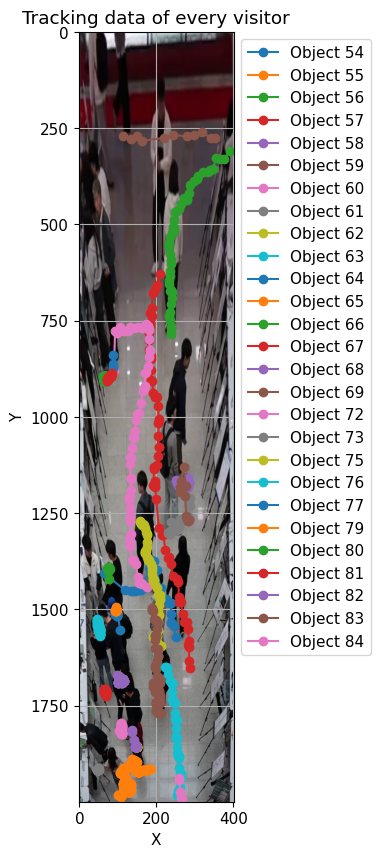

In [111]:
# 각 객체별로 정렬된 좌표에 따라 경로 그리기
plt.figure(figsize=(2, 10))
for obj_id, path in trajectories.items():
    # 시간에 따라 경로 정렬
    sorted_path = sorted(path, key=lambda x: x[0])
    # 경로의 x, y 좌표를 분리
    x_coords, y_coords = zip(*[(x, y) for _, x, y in sorted_path])

    # 경로를 그림
    plt.plot(x_coords, y_coords, marker='o', label=f'Object {obj_id}')

# 시각화 설정
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.imshow(warped_image)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Tracking data of every visitor')
plt.xlim([0,width])
plt.ylim([height,0])
plt.grid(True)
plt.axis('equal')  # 축의 스케일을 동일하게 설정

# 결과 표시
plt.show()


## 히트맵 출력

### 밀도 계산

In [114]:
coords = []
for obj_id, path in trajectories.items():
    for frame, x, y in path:
        coords.append((x, y))
x, y = zip(*coords)

# 그리드 크기와 커널 반경
grid_size = 1
h = 50

# 그리드 설정
x_grid = np.arange(0, width+1, grid_size)
y_grid = np.arange(0, height+1, grid_size)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

def kde_quartic(d, h):
    dn = d / h
    P = (15 / 16) * (1 - dn ** 2) ** 2
    return np.where(dn <= 1, P, 0)

# 밀도 계산을 위한 Numpy 배열 연산
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)
x_mesh_flat = x_mesh.ravel()
y_mesh_flat = y_mesh.ravel()

intensity_list = np.zeros_like(x_mesh, dtype=np.float64)

for i in range(len(x)):
    # 모든 그리드 포인트에 대한 거리 계산
    d = np.sqrt((x_mesh_flat - x[i]) ** 2 + (y_mesh_flat - y[i]) ** 2)

    # 커널 함수 적용
    p = kde_quartic(d, h)

    # 각 그리드 포인트의 밀도 값 업데이트
    intensity_list += p.reshape(x_mesh.shape)

출력

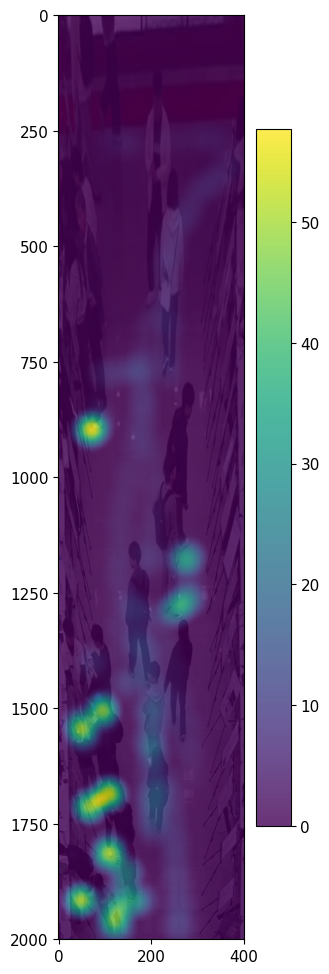

In [116]:
# 결과 시각화
intensity = np.array(intensity_list)
plt.figure(figsize=(3, 12))
plt.imshow(warped_image)
plt.axis('equal')  # 축의 스케일을 동일하게 설정
plt.pcolormesh(x_mesh, y_mesh, intensity, shading='auto', alpha=0.8)
# plt.plot(x, y, 'ro')
plt.xlim([0,width])
plt.ylim([height,0])
plt.colorbar()
plt.show()